In this notebook, we examine our client-selection algorithm (based on Frank-Wolfe) on 1D synthetic dataset.

**Current Optimization Objective**: We minimize the following objective function:
$$
\min_{\{x_i\}_i\in\mathbb{R}} \max_{\lambda_{ij}\in\mathbb{R}}\min_{w_{ij}\in[0,1], i<j} ~\sum_{i=1}^N f_i(x_i) + \sum_{i<j} w_{ij} \left( \lambda_{ij} (x_i - x_j) + \frac{\rho}{2} (x_i - x_j)^2 \right)
- \alpha \mathbb{1}^\top W \mathbb{1}
$$
where $\rho\ge0,\alpha\ge0$ are a constant.

**Future Version**: 

In the future, we will model this as a bilevel optimization problem but with the **same algorithm**
$$
\min_{\{x_i\}_i\in\mathbb{R}} \max_{\lambda_{ij}\in\mathbb{R}} ~\sum_{i=1}^N f_i(x_i) + \sum_{i<j} w_{ij}^\star \left( \lambda_{ij} (x_i - x_j) + \frac{\rho}{2} (x_i - x_j)^2 \right)
$$
where the lower problem is that
$$
w^\star_{ij}(X, \Lambda; \alpha, \rho) = \argmin_{w_{ij}\in[0,1], i<j} \sum_{i<j} w_{ij} \left( \lambda_{ij} (x_i - x_j) + \frac{\rho}{2} (x_i - x_j)^2 \right) - \alpha \mathbb{1}^\top W \mathbb{1}
$$


## Problem Setup
We consider the following 1D problem:
- $N$ clients from $K$ clusters with means $\mu_k$.
- Each client $i\in[N]$ has a quadratic objective $f_i(x)$ (no personalization at the moment)
$$ f_i(x)=\frac{1}{2}(x-\mu_k)^2 $$
- Each time we have access to an **unbiased stochastic** gradient with noise scale $\sigma^2$
$$ g(x) = x - \mu_k+\mathcal{N}(0, \sigma^2)$$ 
    

We define the initializations ($X,\Lambda, W, \mu$) as follows:

In [9]:
import matplotlib.pyplot as plt
import numpy as np 

class BaseSetup(object):
    def __init__(self, K, N, rho, alpha, eta, gamma, sigma, title="", seed=12345):
        self.rng = np.random.Generator(np.random.PCG64(seed))
        self.K = K
        self.N = N
        self.rho = rho
        self.alpha = alpha
        self.eta = eta
        self.gamma = gamma
        self.sigma = sigma
        self.title = title

        self.mu = self._init_mu()
        self.X = self._init_X()
        self.W = self._init_W()
        self.lambda_ = self._init_lambda()
        self.remark = ""

        assert self.mu.shape == (N,)
        assert self.X.shape == (N,)
        assert self.W.shape == (N, N)

    def copy_init(self):
        return self.mu.copy(), self.X.copy(), self.W.copy(), self.lambda_.copy()

    def _init_mu(self):
        assert self.N == 100
        # n_per_cluster = self.N // (self.K//2)
        # return np.array([[k] * n_per_cluster for k in np.arange(self.K)]).flatten()
        return np.array([0] * 40 + [1] * 30 + [2] * 20  + [3] * 10)

    def _init_X(self):
        return self.rng.normal(size=self.N)
    
    def _init_lambda(self):
        return np.zeros((self.N, self.N))

    def gt_cluster(self, i):
        return self.mu[i]

    def _init_W(self):
        raise NotImplementedError

class Setup1(BaseSetup):
    def __init__(self, rho, alpha, eta, gamma, sigma, title="", seed=12345):
        super().__init__(K=10, N=100, rho=rho, alpha=alpha, eta=eta, gamma=gamma, sigma=sigma, title=title, seed=seed)
        self.remark += "Initialize W with Identity;\n"

    def _init_W(self):
        return np.identity(self.N)


class Setup2(BaseSetup):
    def __init__(self, rho, alpha, eta, gamma, sigma, title="", seed=12345):
        super().__init__(K=10, N=100, rho=rho, alpha=alpha, eta=eta, gamma=gamma, sigma=sigma, title=title,seed=seed)
        self.remark += "Initialize W with a matrix of 1s;\n"

    def _init_W(self):
        return np.ones_like(np.identity(self.N))

We define the utility functions (such as gradients/FW/loss as follows):

In [10]:
def grad_x(setup, mu, X, W, Lambda):
    part1 = X - mu + setup.rng.normal(size=setup.N) * setup.sigma
    part2 = (W * Lambda).sum(axis=1)
    part3 = (setup.rho * W * ( np.c_[X] - np.r_[X] )).sum(axis=1)
    return part1 + part2 + part3

def grad_lambda(setup, mu, X, W, Lambda):
    return W * (np.c_[X] - np.r_[X])

def grad_W(setup, mu, X, W, Lambda):
    return Lambda * (np.c_[X] - np.r_[X]) + setup.rho/2 * (np.c_[X] - np.r_[X])**2 - setup.alpha * np.ones_like(W)

def frank_wolfe(setup, mu, X, W, Lambda, t):
    g = grad_W(setup, mu, X, W, Lambda)
    s = (np.sign(-g)+1)//2
    # if t % 10 == 0:
    #     print("t = ", t)
    #     print(g[:4,:4])
    #     print(s[:4, :4])
    #     print(W[:4,:4])
    #     print((W + 2 / (t+2) * (s - W))[:4,:4] )
    W = W + 2 / (t+2) * (s - W)

    # Small fix to the diagonal as they are suppose not to be changed.
    np.fill_diagonal(W, 1)
    return W

class Loss(object):
    def __init__(self, setup, mu, X, W, Lambda):
        self.setup = setup
        # self.mu = mu
        # self.X = X
        # self.W = W
        # self.Lambda = Lambda
    
        self.part1 = ((X - mu)**2/2).sum()
        self.part2 = (W * Lambda * (np.c_[X] - np.r_[X])).sum()
        self.part3 = (setup.rho * W * ( np.c_[X] - np.r_[X] )**2/2).sum()
        self.part4 = - setup.alpha * W.sum()

        self.loss = self.part1 + self.part2 + self.part3

Code block: one experiment one

In [11]:
# For identity matrix
class Run(object):
    def __init__(self, setup, n_iters, loss_fn):
        self.setup = setup
        self.n_iters = n_iters
        self.loss = []
        self.loss_fn = loss_fn

    def run(self):
        mu, X, W, Lambda = self.setup.copy_init()
        for t in range(self.n_iters):
            X -= self.setup.eta * grad_x(self.setup, mu, X, W, Lambda)
            Lambda += self.setup.gamma * grad_lambda(self.setup, mu, X, W, Lambda)
            W = frank_wolfe(self.setup, mu, X, W, Lambda, t)
            self.loss.append( Loss(self.setup, mu, X, W, Lambda) )
        self.mu, self.X, self.W, self.Lambda = mu, X, W, Lambda
        return self

### Experiment 1:

Initial $W$ vs the stochasticity of the gradient $\sigma^2$

In [12]:
class Experiment1(object):
    def __init__(self, n_iters) -> None:
        self.n_iters = n_iters
        # shared
        self.kw = dict(rho=0.1, eta=0.1, gamma=0.1)

        self.setup_runs = [
            Setup1(alpha=0.0, sigma=0.,   title="W=Id," + r"$\sigma=0$", **self.kw),
            Setup1(alpha=0.0, sigma=0.01, title="W=Id," + r"$\sigma=0.01$", **self.kw),
            Setup1(alpha=0.0, sigma=0.1,  title="W=Id," + r"$\sigma=0.1$", **self.kw),
            Setup2(alpha=0.0, sigma=0.,   title="W=E," + r"$\sigma=0$", **self.kw),
            Setup2(alpha=0.0, sigma=0.01, title="W=E," + r"$\sigma=0.01$", **self.kw),
            Setup2(alpha=0.0, sigma=0.1,  title="W=E," + r"$\sigma=0.1$", **self.kw),

            Setup1(alpha=0.001, sigma=0.,   title="W=Id," + r"$\sigma=0$", **self.kw),
            Setup1(alpha=0.001, sigma=0.01, title="W=Id," + r"$\sigma=0.01$", **self.kw),
            Setup1(alpha=0.001, sigma=0.1,  title="W=Id," + r"$\sigma=0.1$", **self.kw),
            Setup2(alpha=0.001, sigma=0.,   title="W=E," + r"$\sigma=0$", **self.kw),
            Setup2(alpha=0.001, sigma=0.01, title="W=E," + r"$\sigma=0.01$", **self.kw),
            Setup2(alpha=0.001, sigma=0.1,  title="W=E," + r"$\sigma=0.1$", **self.kw),
        ] 

    def run(self):
        self.runs = []
        for setup in self.setup_runs:
            run = Run(setup, self.n_iters, Loss).run()
            self.runs.append(run)

experiment1 = Experiment1(1000)
experiment1.run()

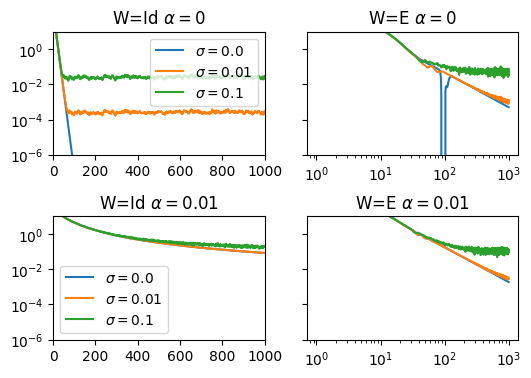

In [13]:
def plot_experiment1(e):
    x = np.arange(1, e.n_iters+1)

    fig, axes = plt.subplots(2, 2, figsize=(6, 4), sharey=True)

    for i in range(3):
        r = e.runs[i]
        setup = e.setup_runs[i]
        label = r"$\sigma=$" + f"{setup.sigma}"
        axes[0, 0].plot(x, [l.loss for l in r.loss], label=label)
    
    axes[0, 0].set_title("W=Id " + r"$\alpha=0$")
    axes[0, 0].legend()
    axes[0, 0].set_xlim(0, e.n_iters)
    axes[0, 0].set_ylim(1e-6, 1e1)
    axes[0, 0].set_yscale("log")

    for i in range(3, 6):
        r = e.runs[i]
        setup = e.setup_runs[i]
        label = r"$\sigma=$" + f"{setup.sigma}"
        axes[0, 1].plot(x, [l.loss for l in r.loss], label=label)

    axes[0, 1].set_title("W=E "  + r"$\alpha=0$")
    axes[0, 1].set_xscale("log")

    for i in range(6,9):
        r = e.runs[i]
        setup = e.setup_runs[i]
        label = r"$\sigma=$" + f"{setup.sigma}"
        axes[1, 0].plot(x, [l.loss for l in r.loss], label=label)
    
    axes[1, 0].set_title("W=Id " + r"$\alpha=0.01$")
    axes[1, 0].legend()
    axes[1, 0].set_xlim(0, e.n_iters)
    axes[1, 0].set_ylim(1e-6, 1e1)
    axes[1, 0].set_yscale("log")

    for i in range(9, 12):
        r = e.runs[i]
        setup = e.setup_runs[i]
        label = r"$\sigma=$" + f"{setup.sigma}"
        axes[1, 1].plot(x, [l.loss for l in r.loss], label=label)

    axes[1, 1].set_title("W=E "  + r"$\alpha=0.01$")
    axes[1, 1].set_xscale("log")

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return fig, axes

_ = plot_experiment1(experiment1)

Analysis of the **above** and **next** figure:

- Upper left subplots: (start with graph with no connection)
    - $\sigma^2=0.$: is a degenerated case because we start with W=I, $\alpha=0$ and $\sigma=0$. Essentially it is equivalent to train locally (sufficient as there is no noise at all).
    - $\sigma^2>0$: still train locally but with noise gradient.
    - The first row of the **next figure** suggest that no changes to the $W$

- Upper right subplots: (start with graph with full connection)
    - The second row of the **next figure** suggest that start with fully connected graph enforces the $W$ to be updated. The connectivity structure can be found more or less, but not certain (green between 0 and 1).

- Lower left and right subplots:
    - As $\alpha > 0$, $W$ is encouraged to form a larger group. (See the 3rd/4th row of **next figure**). It finds the optimal grouping successfully (yellow corresponds to value of 1).


The matrix W at the end of training.


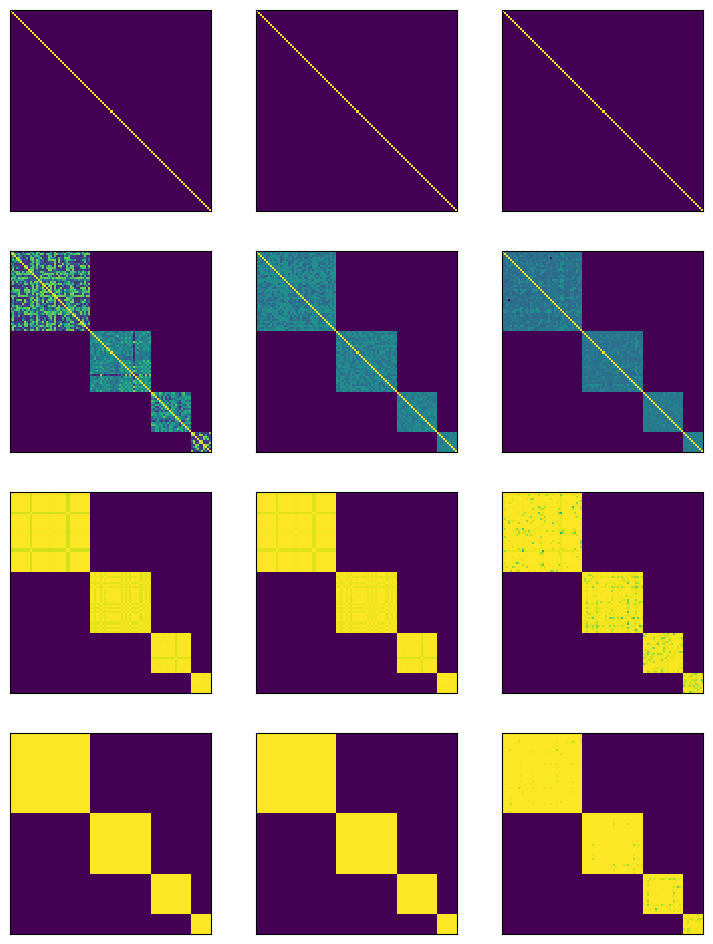

In [14]:
print("The matrix W at the end of training.")
fig, axes = plt.subplots(4, 3, figsize=(9, 12))
for i in range(12):
    axes[i//3, i%3].matshow(np.round(experiment1.runs[i].W, 2))
    axes[i//3, i%3].set_xticks([])
    axes[i//3, i%3].set_yticks([])
